# This is an example of using the KNN/SVM model classifier for face recognition

## This is useful when you wish to recognize a large set of known people, and make a prediction for an unknown person in a feasible computation time.

## Algorithm Description:

The knn classifier is first trained on a set of labeled (known) faces and can then predict the person
in an unknown image by finding the k most similar faces (images with closet face-features under euclidean distance)
in its training set, and performing a majority vote (possibly weighted) on their label.

For example, if k=3, and the five closest face images to the given image in the training set are three image of Thomas and two images of Obama, The result would be 'Thomas'.

This implementation uses a weighted vote, such that the votes of closer-neighbors are weighted more heavily.

# Usage:

1. Prepare a set of images of the known people you want to recognize. Organize the images in a single directory
   with a sub-directory for each known person.

2. Then, call the 'train' function with the appropriate parameters. Make sure to pass in the 'model_save_path' if you
   want to save the model to disk so you can re-use the model without having to re-train it.

3. Call 'predict' and pass in your trained model to recognize the people in an unknown image.

In [1]:
import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw, ImageFont
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

# 1, Extract face embeddings from the train directory with subdirs and files

Directory structure:

1, train_dir/Thomas Canhao Xu/xxx.jpg ...

2, train_dir/Barack Obama/yyy.jpg ...

3, train_dir/Donald Trump/zzz.jpg ...

4, ...

In [2]:
train_dir = "./train"
X = []
y = []

for class_dir in os.listdir(train_dir):
    if not os.path.isdir(os.path.join(train_dir, class_dir)):
        continue

    print("Processing face for: ", class_dir, end="")
    for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
        image = face_recognition.load_image_file(img_path)
        face_bounding_boxes = face_recognition.face_locations(image)

        # If there are no people (or too many people) in a training image, skip the image.
        if len(face_bounding_boxes) != 1:
            print("{} skipped: {}".format(img_path, "No face" if len(face_bounding_boxes) < 1 else ">1 face"))
        else:
            X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
            y.append(class_dir)
            print("+", end="")
    print("Done")

print("Face embedding extraction complete! Total {} pictures.".format(len(X)))

Processing face for:  lzm+++++++./train/lzm/04.jpg skipped: No face
Done
Processing face for:  xiumin+++++++Done
Face embedding extraction complete! Total 14 pictures.


# 2, You can analyze and visualize the faces by using 3D PCA, same as before, but with more data

In [6]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family'] = 'monospace'

X_lzm = []
X_xiumin = []

for i in range(0, 6):
    X_lzm.append(X[i])
for i in range(6, 14):
    X_xiumin.append(X[i])

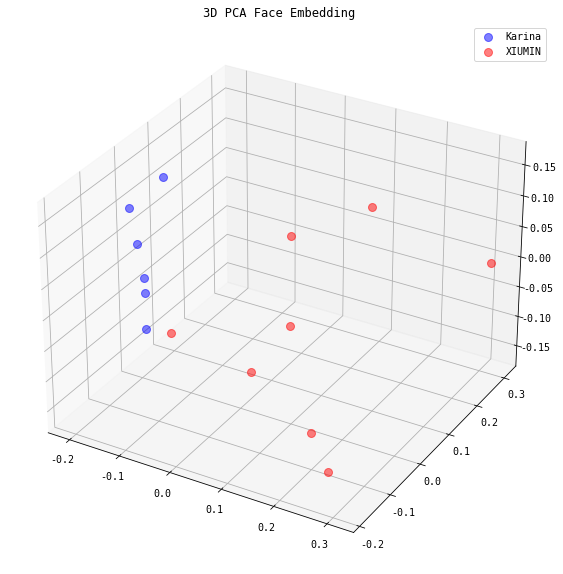

In [7]:
pca = PCA(n_components=3).fit(X)
Xd_lzm = pca.transform(X_lzm)
Xd_xiumin = pca.transform(X_xiumin)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(Xd_lzm[:,0], Xd_lzm[:,1], Xd_lzm[:,2],
        'o', markersize=8, color='blue', alpha=0.5, label='Karina')
ax.plot(Xd_xiumin[:,0], Xd_xiumin[:,1], Xd_xiumin[:,2],
        'o', markersize=8, color='red', alpha=0.5, label='XIUMIN')

plt.title('3D PCA Face Embedding')
ax.legend(loc='upper right')

plt.show()

# 3, Using the face embedding array, train a KNN classifier

In [8]:
n_neighbors = 2

if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))

knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='ball_tree', weights='distance')
knn_clf.fit(X, y)

with open('./knn_model_trained.clf', 'wb') as f:
    pickle.dump(knn_clf, f)

# 4, Using the face embedding array, train a SVM classifier

In [9]:
from sklearn import svm

svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X, y)

with open('./svm_model_trained.clf', 'wb') as f:
    pickle.dump(svm_clf, f)

# 5, Find faces with trained classifier

In [12]:
test_image = face_recognition.load_image_file('train/lzm/05.jpg')

face_locations = face_recognition.face_locations(test_image)
no = len(face_locations)
print("Number of faces detected: ", no)

print("Found:")
for i in range(no):
    test_image_enc = face_recognition.face_encodings(test_image)[i]
    name = knn_clf.predict([test_image_enc])
    print(*name)

Number of faces detected:  1
Found:
lzm


# 6, Find a bunch of pictures and mark them with name

In [13]:
def predict(X_img_path, model_path=None, distance_threshold=0.6):
    with open(model_path, 'rb') as f:
        model_clf = pickle.load(f)

    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)
    if len(X_face_locations) == 0:
        return []

    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)
    closest_distances = model_clf.kneighbors(faces_encodings, n_neighbors=2)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(model_clf.predict(faces_encodings), X_face_locations, are_matches)]

In [14]:
image_dir = './'
for image_file in os.listdir(image_dir):
    if image_file.endswith((".jpg", ".png")):
        full_file_path = os.path.join(image_dir, image_file)
        print("Looking for faces in {}".format(image_file))

        predictions = predict(full_file_path, model_path="./knn_model_trained.clf")

        for name, (top, right, bottom, left) in predictions:
            print("- Found {} at ({}, {})".format(name, left, top))

        pil_image = Image.open(os.path.join(image_dir, image_file)).convert("RGB")
        draw = ImageDraw.Draw(pil_image)
        
        for name, (top, right, bottom, left) in predictions:
            draw.rectangle(((left, top), (right, bottom)), outline=(255, 0, 0), width=10)
            fnt = ImageFont.truetype("simhei.ttf", 40)
            text_width, text_height = draw.textsize(name, font = fnt)
            draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(255, 0, 0), outline=(255, 0, 0), width=5)
            draw.text((left + 6, bottom - text_height - 5), name, font = fnt, fill=(255, 255, 255, 255))
            
        del draw
        display(pil_image)